# Phase Loss

**Background**


In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
from PIL import Image
import time
import h5py
import pandas as pd
from condensate import Wavefunction, Environment, hbar
%matplotlib inline


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle

figpath = 'figures/phaseML/'

# Prepare state

In [80]:
omega   = 2*np.pi*10
epsilon = 0.0
dt = 1e-5
fov = 150e-6
DIM=256
steps = 5000

e = Environment(DIM=DIM, fov=fov, N=1e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)
e.rotating_frame(omegaR=[0.1*omega]*steps)


            Running condensate on 256x256 grid with:
            atom number: 1e+05 
            mass:        3.80e-26
        


In [81]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100, vortexnumber=1)
groundstate.relax(vmax=3e8, dt=dt, steps=steps)

In [4]:
groundstate.env.spoon

{'type': None,
 'strength': 100000.0,
 'radius': 2e-05,
 'leapx': -250,
 'leapy': 500,
 'leapxscale': 1,
 'leapyscale': 1,
 'zcontrol': False}

In [5]:
groundstate.env.spoon['type'] = 'mouse'
groundstate.env.spoon['strength'] = 1e2
groundstate.env.spoon['radius'] = 5e-6

groundstate.evolve(dt=1e-5, steps=0)

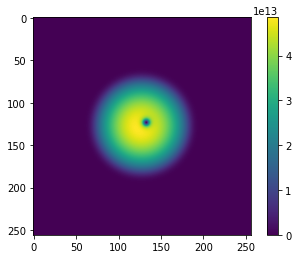

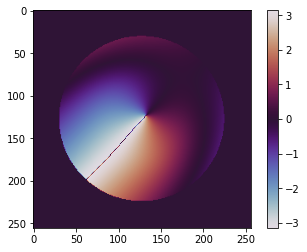

In [82]:
groundstate.show_density()
groundstate.show_phase()
psi = groundstate.Psi.copy()

# Design Phase loss

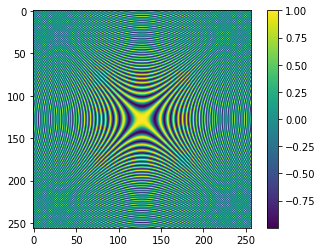

In [75]:
x = np.linspace(-5,5,DIM)
xx, yy = np.meshgrid(x, x)
 
# phase = xx * yy
phase = (xx + yy)*(xx- yy)
# phase = np.arctan(yy/xx)

plt.imshow(np.exp(9j * phase).real)
plt.colorbar()

In [76]:
def getimage(psi):
    psi = psi.copy()
    psi = psi[::2,::2]
    n = np.abs(psi)**2
    nimg = [255*n/n.max(),255*n/n.max(),255*n/n.max()]
    rg = np.array([np.real(psi), np.imag(psi),0*np.real(psi)])
    phiimg = 255*(rg+1.2*np.max(np.real(psi)))/(2.4*np.max(np.real(psi)))
    allimg = np.hstack([nimg,phiimg]).T
    return Image.fromarray(np.uint8(allimg))

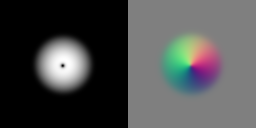

In [77]:

Im = getimage(psi*np.exp(0*phase + 3j))
# Im.save(figpath + 'vortexcolor2.png')
Im

In [83]:
test2 = psi

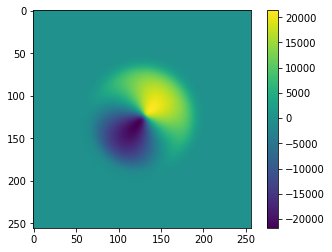

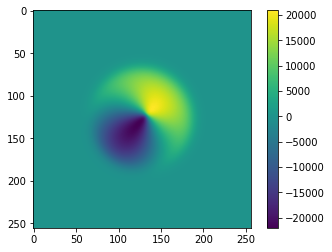

In [84]:
# test= psi 
# plt.figure()
plt.imshow(test.real)
plt.colorbar()
# test2= test  * np.exp(0*phase + 3j)
plt.figure()
plt.imshow(test2.real)
plt.colorbar()

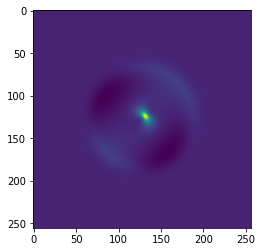

In [85]:
plt.imshow(test.real - test2.real)

(-0.5, 255.5, 255.5, -0.5)

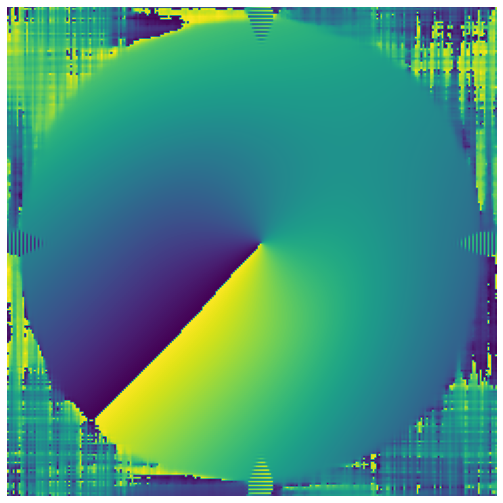

In [87]:

plt.figure(figsize=(9,9))
plt.imshow(np.angle(test2 ))
plt.axis('off')
# plt.savefig(figpath+'anglevortex2.png')

In [97]:
sss = np.array(np.gradient(np.angle(test)))
normgrads = np.linalg.norm(sss, axis=0)
# normgrads[normgrads>1] = 0
sss[0,normgrads>2] = 0
sss[1,normgrads>2] = 0

(-5.4980392156862745,
 5.458823529411765,
 -5.4980392156862745,
 5.458823529411765)

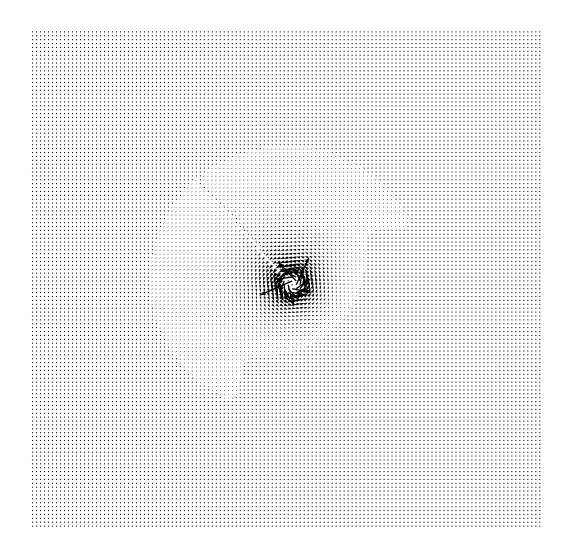

In [98]:
vx,vy = sss
vx *= np.abs(test2)>1e3
vy *= np.abs(test2)>1e3

skip=2
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vy[::skip,::skip],vx[::skip,::skip], scale=10)

plt.axis('off')
# plt.savefig(figpath + 'vortexquiver2.png')

(-0.5, 255.5, -0.5, 255.5)

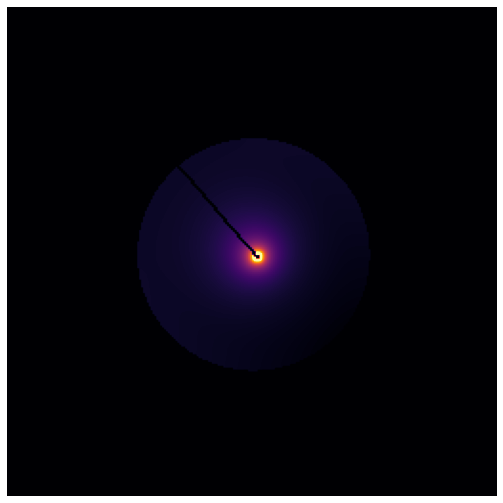

In [99]:
normgrads[normgrads>1] = 0
normgrads*= np.abs(test)>5000
plt.figure(figsize=(9,9))
plt.imshow(normgrads,vmax=.4, origin='lower', cmap='inferno')
plt.axis('off')
# plt.savefig(figpath + 'vortexgrads1.png')

In [100]:
def phase_loss(psi1, psi2, nthresh=5e2):
    psi1, psi2 = psi1.copy(), psi2.copy()
    
    grads1 = np.array(np.gradient(np.angle(psi1)))
    grads2 = np.array(np.gradient(np.angle(psi2)))
    
    normgradloss = np.linalg.norm(grads1 - grads2, axis=0)
    normgradloss[normgradloss>1] = 0
    normgradloss *= np.abs(psi1)>nthresh
    return normgradloss
    

In [101]:
out = phase_loss(test,test2, nthresh=1e1)

(-0.5, 255.5, 255.5, -0.5)

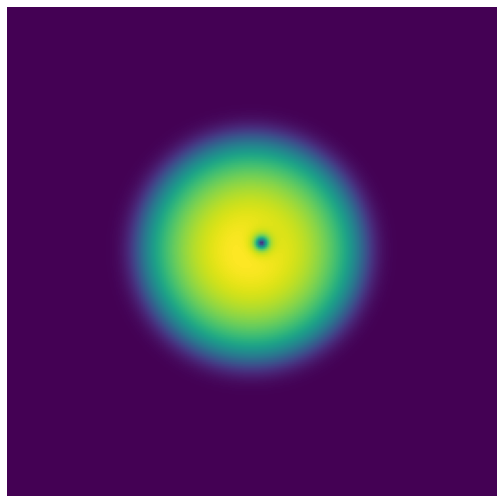

In [102]:
plt.figure(figsize=(9,9))
plt.imshow(np.abs(test2))
plt.axis('off')
# plt.savefig('figures/phaseML/vortexn1.png')

(-0.5, 255.5, 255.5, -0.5)

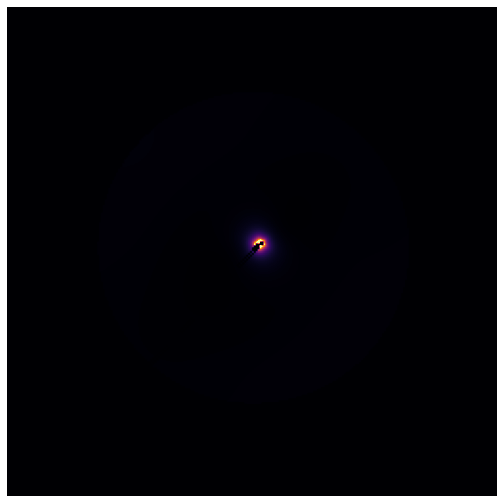

In [103]:
plt.figure(figsize=(9,9))
plt.imshow(out, vmax=.5, cmap='inferno')
plt.axis('off')
# plt.savefig('figures/phaseML/vortex_diff_3.png')

In [105]:
np.sum(np.abs(out))

133.06660728492417

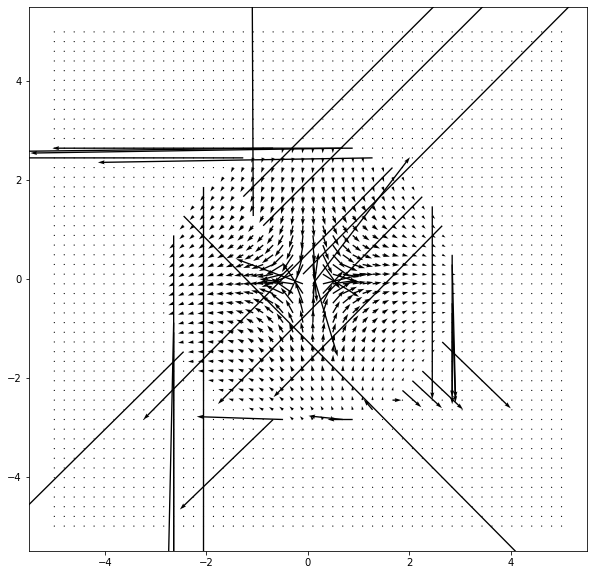

In [136]:

vx, vy = np.gradient(np.angle(test)*(np.abs(test)>5e2))
alal = [np.linalg.norm([vxx,vyy]) for (vxx,vyy) in zip(vx.flatten(), vy.flatten())]

vx2, vy2 = np.gradient(np.angle(test2)*(np.abs(test2)>5e2))
alal2 = [np.linalg.norm([vxx,vyy]) for (vxx,vyy) in zip(vx2.flatten(), vy2.flatten())]

skip=5
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vx[::skip,::skip],vy[::skip,::skip])

(0.0, 1000.0)

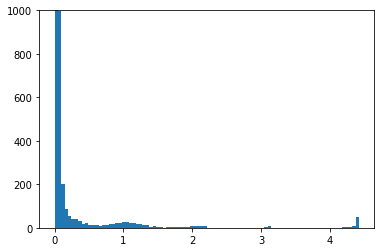

In [137]:
plt.hist(alal2, bins=90)
plt.ylim([0,1000])

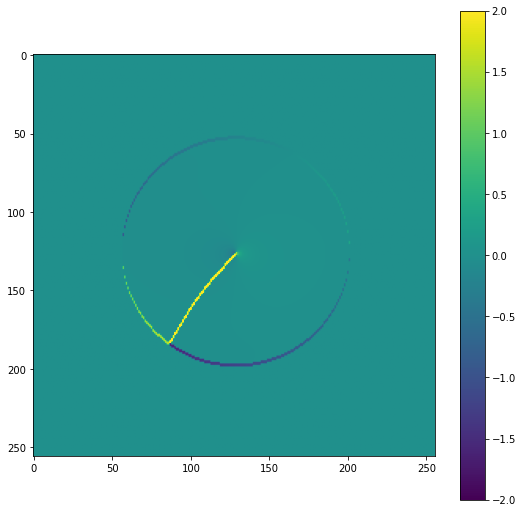

In [141]:
plt.figure(figsize=(9,9))
plt.imshow(vx, vmin=-2,vmax=2)
plt.colorbar()

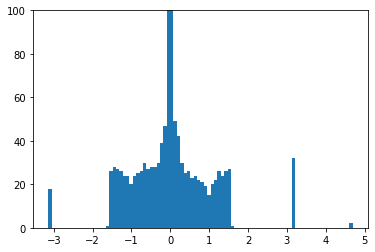

In [142]:
plt.hist((vx-vx2).flatten(), bins=90)
plt.ylim([0,100])
plt.show()

# Generate an 'easy' vortex lattice dataset

In [58]:
omega   = 2*np.pi*10
epsilon = 0.0
dt = 4e-4
fov = 150e-6
DIM=256
steps = 50

e = Environment(DIM=DIM, fov=fov, N=2e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 256x256 grid with:
            atom number: 2e+05 
            mass:        3.80e-26
        


In [59]:
vortexnumbers = np.arange(0,10,2)
omegas = [0.2,0.5,0.7]
stepsrep=10

In [61]:
dsname='vlattice'
datafile='data/vlatticeML.hdf5'
out = []
params = []

for omegafrac in tqdm(omegas):
    e.rotating_frame(omegaR=[omegafrac*omega]*steps)
    for vortexnumber in tqdm(vortexnumbers, leave=False):
        groundstate = Wavefunction(e)
        groundstate.initialize_Psi(width=100, vortexnumber=vortexnumber)
        for i in tqdm(range(stepsrep), leave=False):
            groundstate.relax(vmax=3e8, dt=dt, steps=steps)
            out.append(groundstate.Psi.copy())
            params.append([vortexnumber,omegafrac, i*steps])
                
with h5py.File(datafile, 'a') as f:
    dset = f.create_dataset(dsname, data=np.array(out))
    dset.attrs['params'] = params

In [63]:
with h5py.File('data/vlatticeML.hdf5', 'r') as f:
    names = [name for name in f]
    print(names[0])
    dset = f[names[0]]
    clouds = dset[()]

vlattice


In [65]:
len(clouds)

150

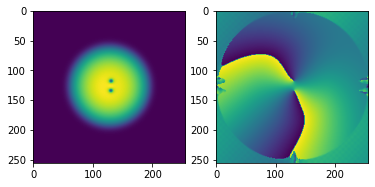

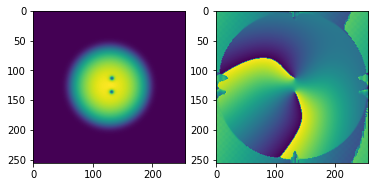

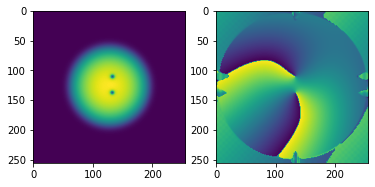

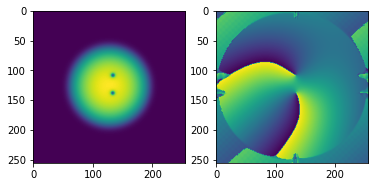

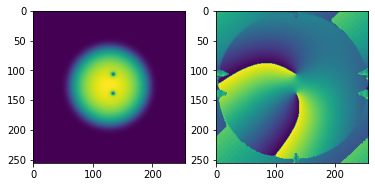

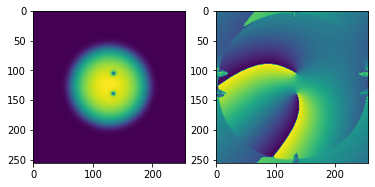

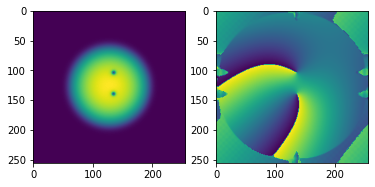

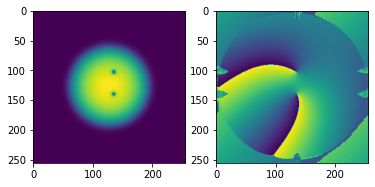

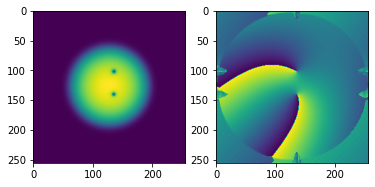

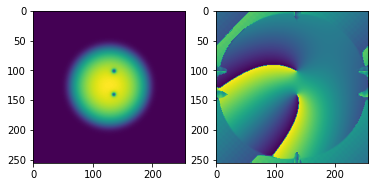

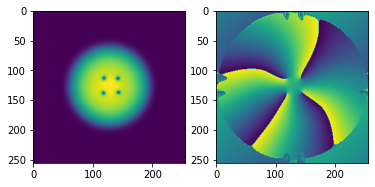

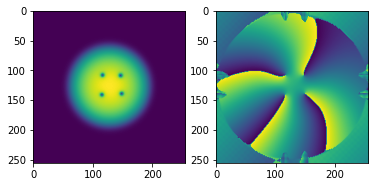

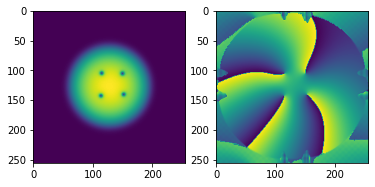

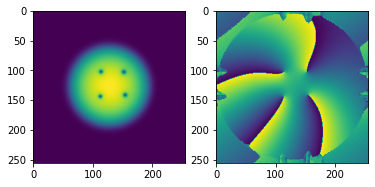

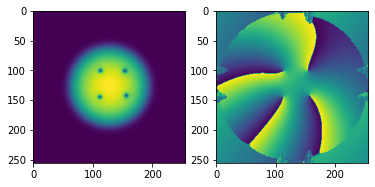

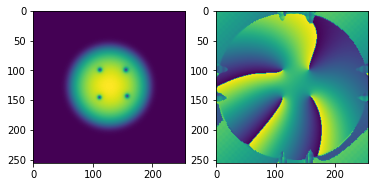

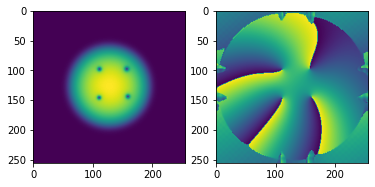

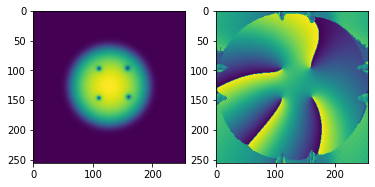

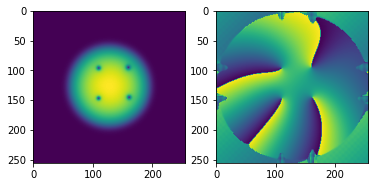

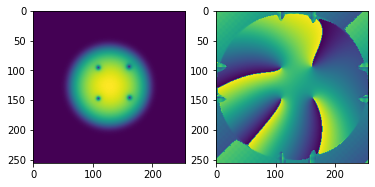

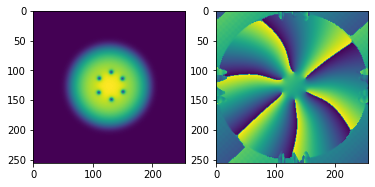

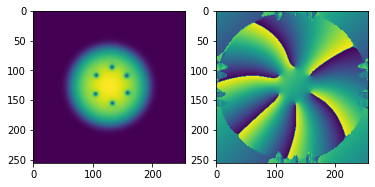

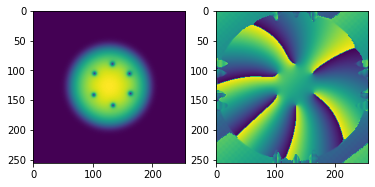

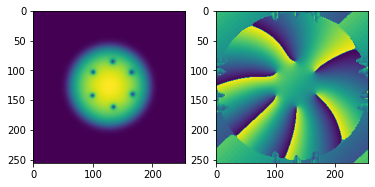

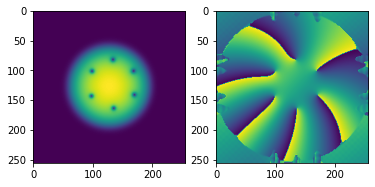

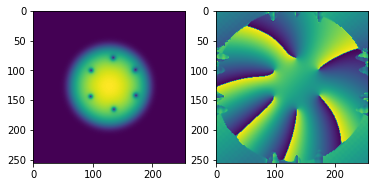

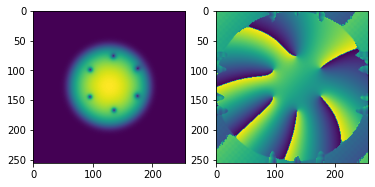

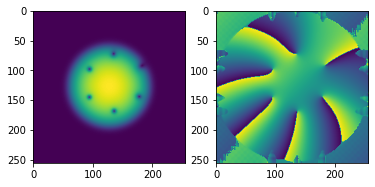

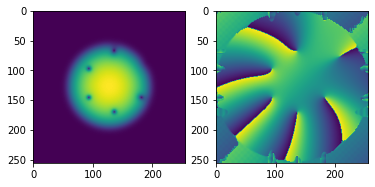

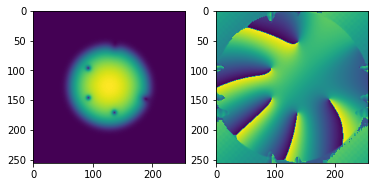

In [64]:
for cloud in clouds[10:40]:
    f,axarr = plt.subplots(ncols=2)
    axarr[0].imshow(np.abs(cloud))
    axarr[1].imshow(np.angle(cloud))
    
    plt.show()

# Hard vortex dataset for SRGAN

In [10]:
omega   = 2*np.pi*10
epsilon = 0.0
dt = 4e-4
fov = 150e-6
DIM=512
steps = 50

e = Environment(DIM=DIM, fov=fov, N=5e7)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 5e+07 
            mass:        3.80e-26
        


In [11]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=600)
groundstate.relax(vmax=1e8, dt=1e-6, steps=3000, showevery=100)
groundstate.env.spoon['type'] = 'mouse'
groundstate.env.spoon['strength'] = 1e2
groundstate.env.spoon['radius'] = 5e-6

In [12]:
start = deepcopy(groundstate)
start.evolve(vmax=1e8, dt=5e-5, steps=500, showevery=100, cooling=0.0)

In [13]:

start.evolve(vmax=1e8, dt=1e-6, steps=300, showevery=100, cooling=0.1)

In [14]:

start.env.spoon['type'] = 'mouse'
start.env.spoon['strength'] = 1e4
start.env.spoon['radius'] = 5e-6
start.evolve(vmax=1e8, dt=1e-7, steps=30000, showevery=100, cooling=0.0001)

In [7]:
start.env.spoon

{'type': 'mouse',
 'strength': 100.0,
 'radius': 5e-06,
 'leapx': -250,
 'leapy': 500,
 'leapxscale': 1,
 'leapyscale': 1,
 'zcontrol': False}